# Figures 

## ECCO

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 288, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_slt                (time, sigma2_bin) float64 7.888e+04 7.888e+04 ... 0.0
    R2_th                 (time, sigma2_bin) float64 7.888e+04 7.888e+04 ... 0.0
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_slt           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv_th            (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

In [4]:
#indices
indices1 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/indices.zarr'))
si = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ecco_si_index.zarr')).load()

In [5]:
ind = xr.merge([indices1, si])
indices = ind.drop('ecco')

In [6]:
indices

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k                (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    enso             (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    fw_flx           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    heat_flx         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sam              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    windstress_curl  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ecco_si_index    (time) float32 -1.226 -0.5114 0.5835 ... 0.6039 -3.058

## Time mean budgets

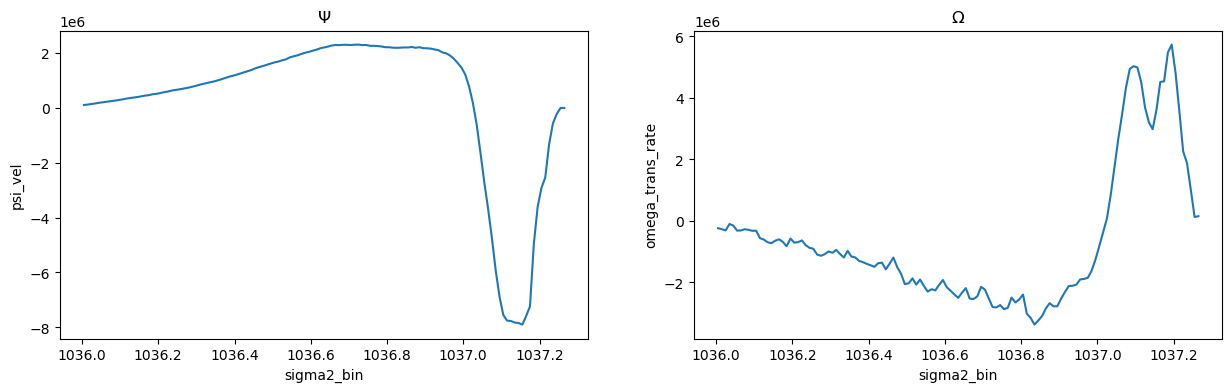

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

**New deep/bottom water boundary is 1037.155 $\frac{kg}{m^3}$**

### $\frac{\partial V}{\partial t}$

In [10]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.155, method='nearest'))/1e6
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.155, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))/1e6

In [11]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(2.810723)

In [12]:
bottom.dVdt + deep.dVdt#+ ((wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6)

<xarray.DataArray 'dVdt' ()>
array(-9.5e-06)

### E-P-R

### $\Omega$

In [13]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.155, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(3.60666655)

In [14]:
terms_on_boundary = wmt_budget_terms.sel(sigma2_bin=1037.155, method='nearest')/1e6
terms_on_boundary

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
    sigma2_bin            float64 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/24)
    R1                    (time) float64 nan 0.5772 -5.009 ... 1.066 -0.5081 nan
    R2                    (time) float64 nan 0.9368 1.229 ... 2.64 2.107 nan
    R2_slt                (time) float64 0.9262 2.975 0.8656 ... 3.07 4.206
    R2_th                 (time) float64 7.917 6.136 7.365 ... 5.715 4.838 3.204
    R3                    (time) float64 nan -0.05857 -0.09452 ... 0.04567 nan
    R3_slt                (time) float64 nan -0.001332 ... -7.374e-05 nan
    ...                    ...
    omega_trans_rate_slt  (time) float64 nan 6.388 7.259 ... 7.121 3.874 nan
    omega_trans_rate_th   (time) float64 nan -12.5 -11.14 ... -6.423 -6.261 nan
    psi_adv               (time) float64 nan -7.237 -5.771 ... -4.952 -3.694 nan
    psi_adv_slt           (time) float64 -6.756 -5.199 -6.135 ... -2.731 -1.886
    psi_adv_th            (time) float64 nan nan 0.3638 ... -1.877 nan nan
    psi_vel               (time) float32 nan -8.173 -7.001 ... -7.592 -5.801 nan

In [15]:
omegas = list()
bdy_omegas = list()

for var in terms_on_boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        bdy_omegas.append(terms_on_boundary.drop('sigma2_bin').data_vars[var])

In [16]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [17]:
len(omegas)

9

In [18]:
len(bdy_omegas)

9

In [20]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


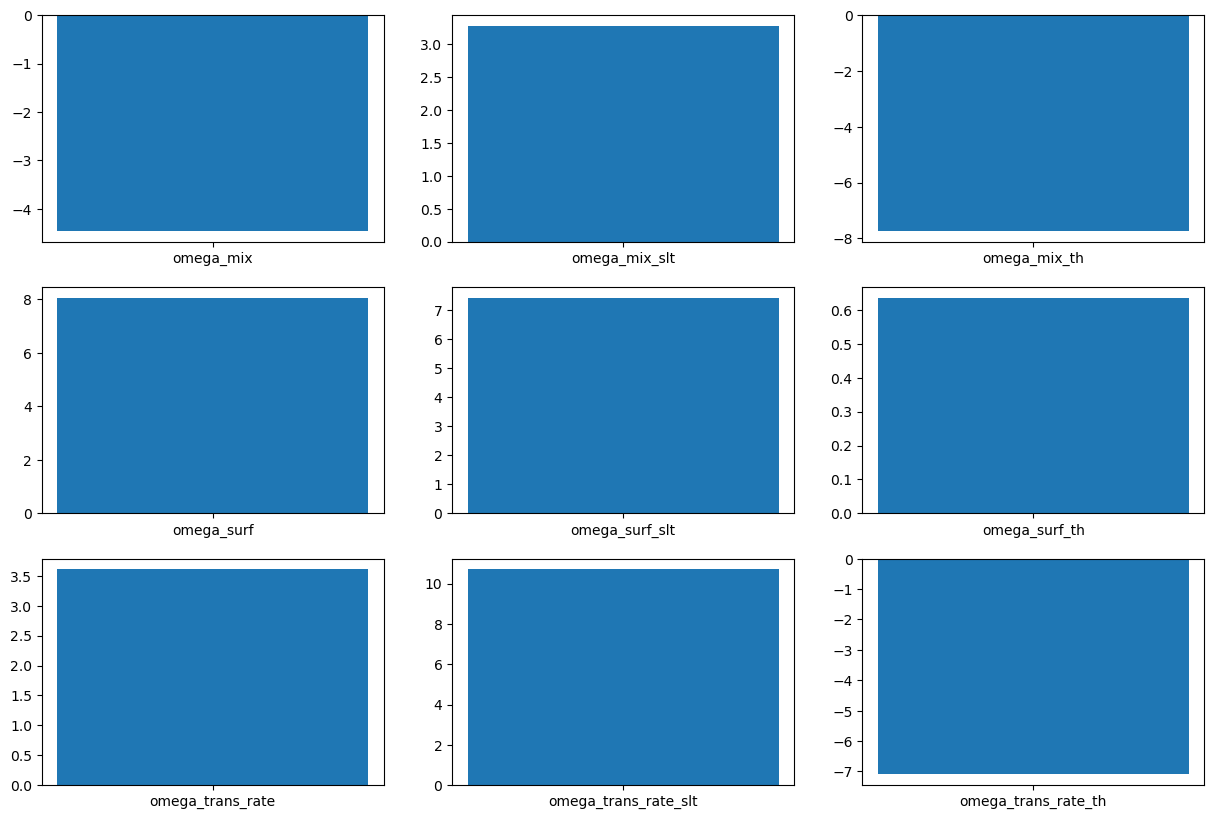

In [21]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bdy_omegas[i].name, height=bdy_omegas[i].mean('time').values)

In [22]:
- bottom.omega_trans_rate + bottom.omega_mix + bottom.omega_surf

<xarray.DataArray ()>
array(3.55271368e-15)

In [23]:
whole_colmn = wmt_budget_terms.sum('sigma2_bin')/1e6

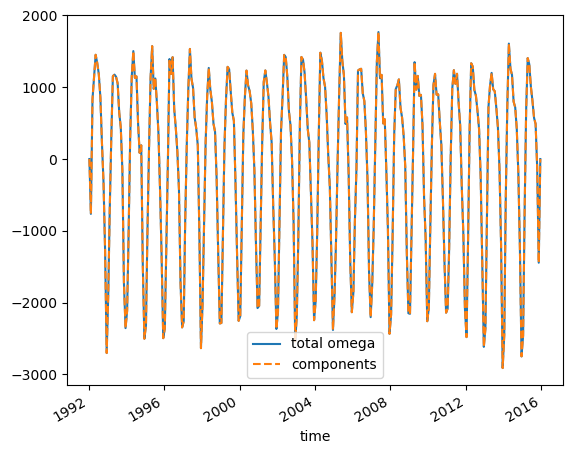

In [24]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_trans_rate_slt + whole_colmn.omega_trans_rate_th).plot(label='components', linestyle='--')
plt.legend()

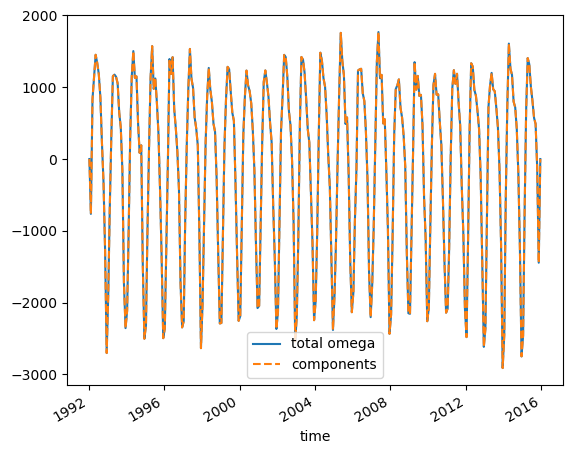

In [25]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_surf + whole_colmn.omega_mix ).plot(label='components', linestyle='--')

plt.legend();

In [26]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [28]:
bdy_omegas[3].name

'omega_surf'

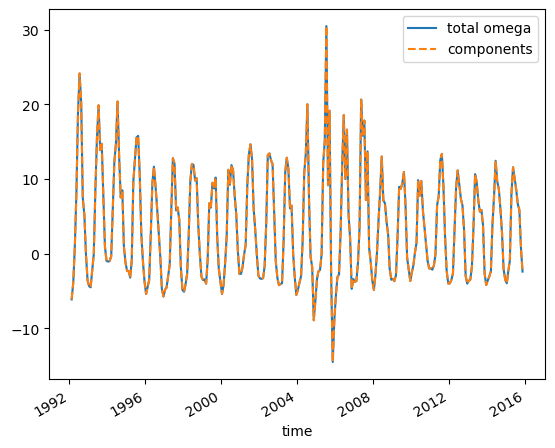

In [29]:
bdy_omegas[-3].plot(label='total omega')
(bdy_omegas[3] + bdy_omegas[0]).plot(label='components', linestyle='--')

plt.legend();

In [32]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


In [36]:
bdy_omegas[-3].name

'omega_trans_rate'

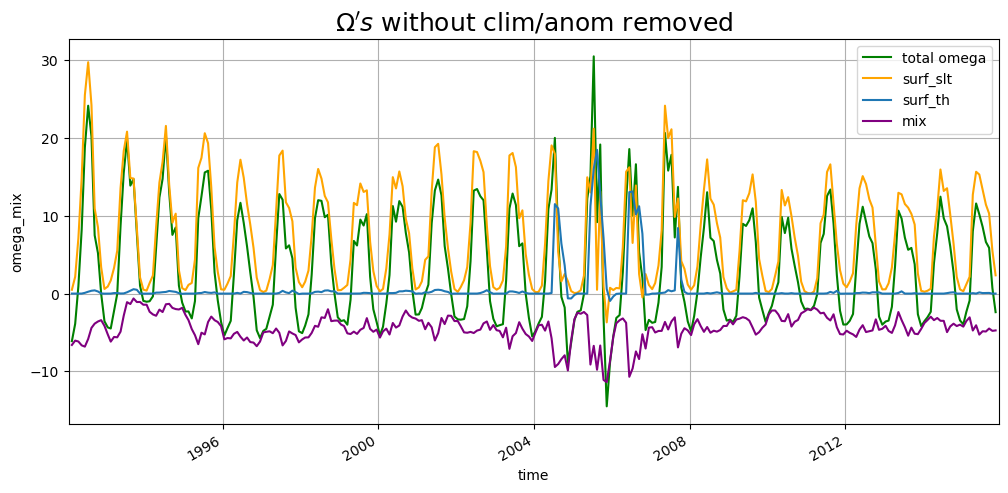

In [37]:
plt.figure(figsize=(12,5))
bdy_omegas[-3].plot(label='total omega', color='green')
bdy_omegas[4].plot(label='surf_slt', color='orange')
bdy_omegas[5].plot(label='surf_th', color='C0')
bdy_omegas[0].plot(label='mix', color='purple')

plt.xlim(wmt_budget_terms.time[0], wmt_budget_terms.time[-1])
plt.title(r"$\Omega's$ without clim/anom removed", fontsize=18)

plt.grid()
plt.legend();

### Budget

* $\frac{\partial V}{\partial t} = \Omega_{total} + R1$ $\Omega_{total} \equiv$ hist(weights=tottend); tottend = $\sigma$.diff(time)*vol / $\Delta$ t
* $\Omega_{trans-rate}$
* $\Psi_{adv} = \Psi_{vel} + R2$
* $R3 = \Omega_{total} - \Psi_{adv} - \Omega_{trans-rate}$
* $\frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1$

__SWITCH SIGN OF ALL TERMS SINCE CUM VOL WAS DEFINED $\int_{\sigma_{max}}^{\sigma_{min}}$ (instead of $\int_{\sigma_{min}}^{\sigma_{max}}$) in wmt budget `poster-figs-sigma-ecco-ts-components-SOSEperiod.ipynb`__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [38]:
print('bottom:', bottom.dVdt.values, ' deep:', deep.dVdt.values)

bottom: 2.810723  deep: -2.8107325


In [39]:
print('bottom:', bottom.psi_vel.values, ' deep:', deep.psi_vel.values)

bottom: 7.8996105  deep: -7.823914


In [40]:
print('bottom:', bottom.omega_trans_rate.values, ' deep:', deep.omega_trans_rate.values)

bottom: -3.5838631896572415  deep: 3.6066665514499445


In [41]:
bottom = -bottom
deep = -deep

In [42]:
print('correct bottom:', bottom.dVdt.values, ' correct deep:', deep.dVdt.values)

correct bottom: -2.810723  correct deep: 2.8107325


In [43]:
print('correct bottom:', bottom.psi_vel.values, ' correct deep:', deep.psi_vel.values)

correct bottom: -7.8996105  correct deep: 7.823914


In [44]:
print('correct bottom:', bottom.omega_trans_rate.values, ', correct deep:', deep.omega_trans_rate.values, ', omega on bdy:', 
      bdy_omegas[6].mean('time').values)

correct bottom: 3.5838631896572415 , correct deep: -3.6066665514499445 , omega on bdy: 3.6066665514499445


### __Bottom budget__

In [45]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


In [46]:
bdy_omegas[-3].name

'omega_trans_rate'

In [78]:
- bottom.dVdt + bottom.psi_vel + bottom.R2 + bdy_omegas[-3].mean('time') + bottom.R1 + bottom.R3

<xarray.DataArray ()>
array(0.02280161)

In [48]:
- bottom.dVdt + bottom.psi_vel + bottom.R2 + bottom.omega_trans_rate + bottom.R1 + bottom.R3

<xarray.DataArray ()>
array(-1.75341583e-06)

### __Deep budget__

In [49]:
- deep.dVdt + deep.psi_vel + deep.R2 + deep.omega_trans_rate + deep.R1 + deep.R3

<xarray.DataArray ()>
array(2.07689853e-06)

In [50]:
- deep.dVdt + deep.psi_vel + deep.R2 - bdy_omegas[-3].mean('time') + deep.R1 + deep.R3

<xarray.DataArray ()>
array(2.07689853e-06)

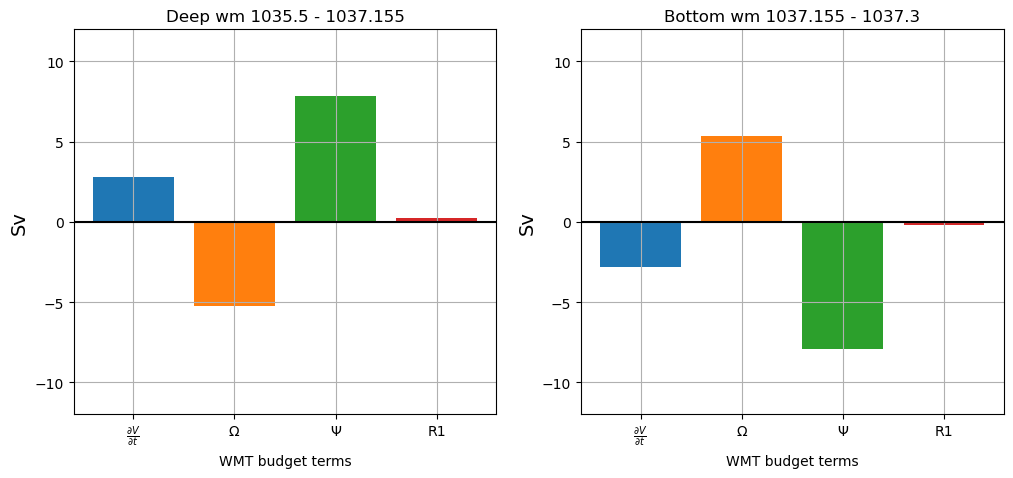

In [51]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt)
ax0.bar(x=r'$\Omega$', height = (deep.omega_trans_rate + deep.R2))
ax0.bar(x=r'$\Psi$', height=deep.psi_vel)
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1)
#ax0.bar(x='R3', height=deep.R3)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1035.5 - 1037.155')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt)
ax1.bar(x=r'$\Omega$', height = (bottom.omega_trans_rate + bottom.R2))
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel)
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1)
#ax1.bar(x='R3', height=bottom.R3)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.155 - 1037.3')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
ax1.set_ylim(-12,12);

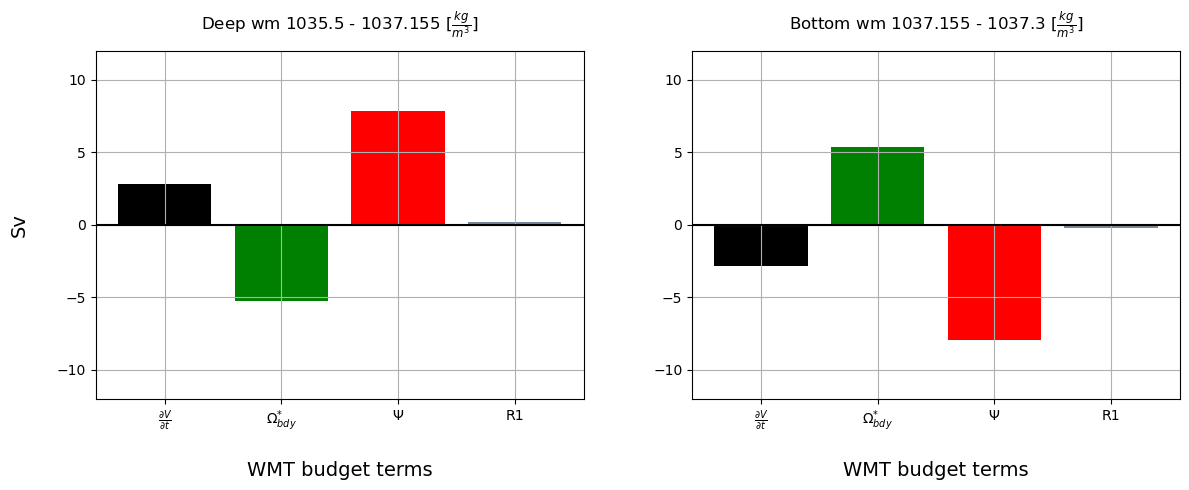

In [52]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt, color='k')
ax0.bar(x=r'$\Omega^{*}_{bdy}$', height = (- bdy_omegas[6].mean('time') + deep.R2), color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1, color='lightslategray')
#ax0.bar(x='R3', height=deep.R3, color='purple')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1035.5 - 1037.155 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14, labelpad=20)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt, color='k')
ax1.bar(x=r'$\Omega^{*}_{bdy}$', height = (bdy_omegas[6].mean('time') + bottom.R2), color='green')
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel, color='red')
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1, color='lightslategray')
#ax1.bar(x='R3', height=bottom.R3, color='purple')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.155 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-12,12)
plt.tight_layout(w_pad=5);

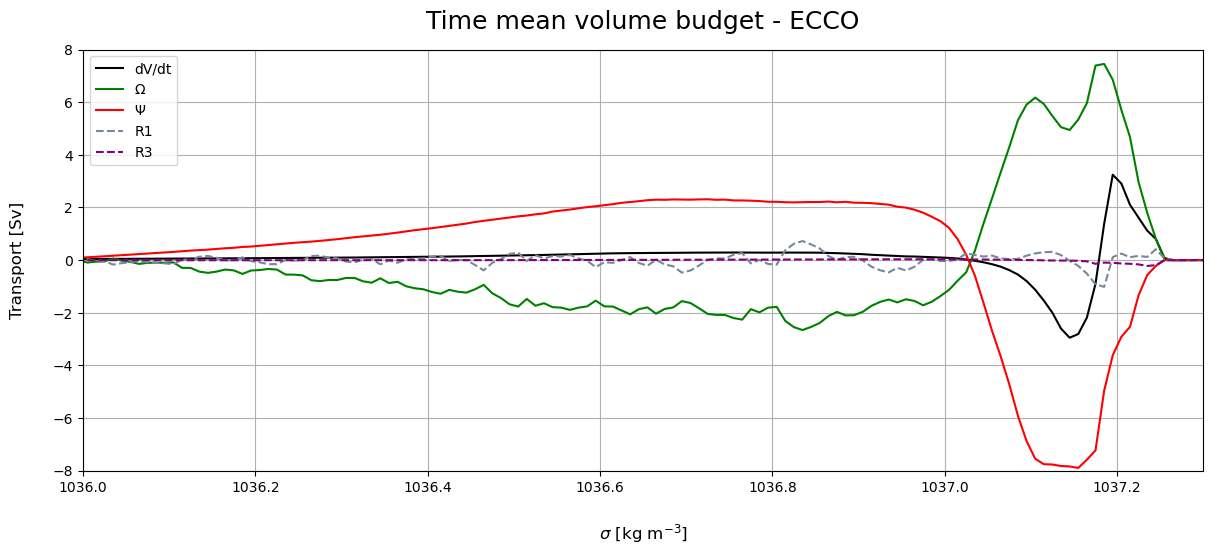

In [53]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
((wmt_budget_terms.omega_trans_rate+wmt_budget_terms.R2)/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--')
(wmt_budget_terms.R3/1e6).mean(dim='time').plot(label='R3', color='purple', linestyle='--')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 8)
plt.xlim(1036, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean volume budget - ECCO', fontsize=18, pad=15);

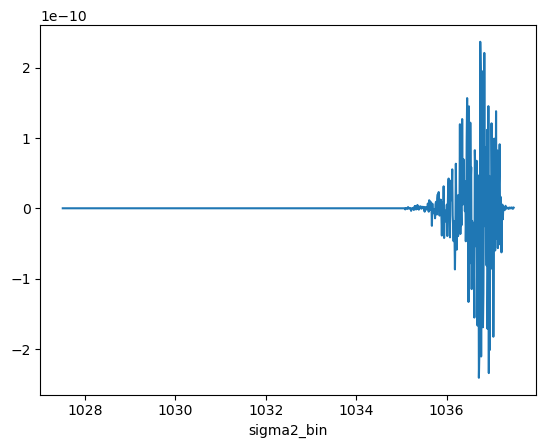

In [109]:
(- wmt_budget_terms.omega_trans_rate + wmt_budget_terms.omega_mix + wmt_budget_terms.omega_surf).mean('time').plot()

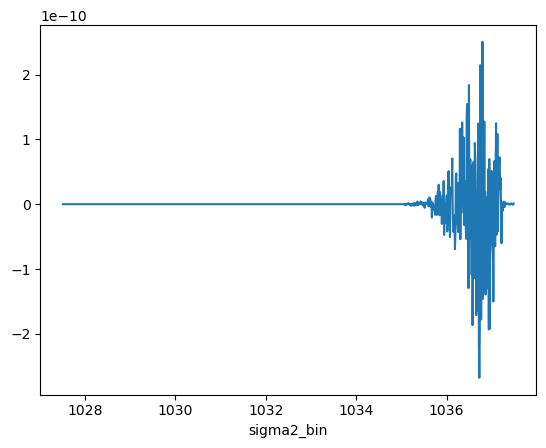

In [110]:
(- wmt_budget_terms.omega_trans_rate + wmt_budget_terms.omega_mix + 
 wmt_budget_terms.omega_surf_slt + wmt_budget_terms.omega_surf_th).mean('time').plot()

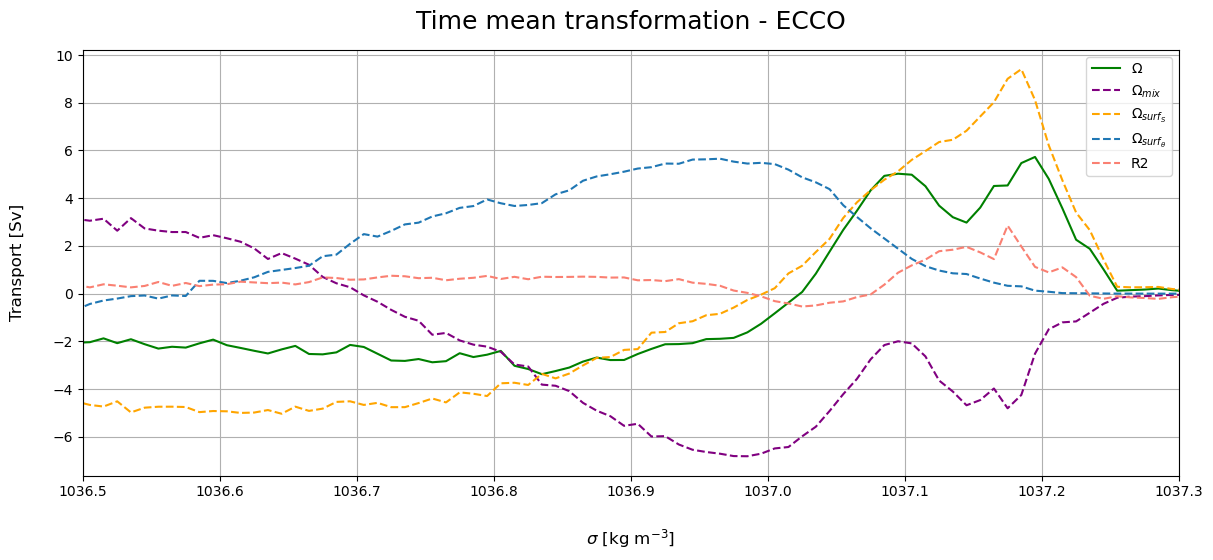

In [54]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', figsize=(12,5))
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')

plt.legend()
plt.grid()
#plt.ylim(-6, 9)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean transformation - ECCO', fontsize=18, pad=15);

### Defining no POlynya years

In [55]:
polynya_yrs = wmt_budget_terms.time.sel(time=slice('2004', '2007')).values
polynya_yrs

array(['2004-01-15T00:00:00.000000000', '2004-02-13T00:00:00.000000000',
       '2004-03-15T00:00:00.000000000', '2004-04-14T00:00:00.000000000',
       '2004-05-15T00:00:00.000000000', '2004-06-14T00:00:00.000000000',
       '2004-07-15T00:00:00.000000000', '2004-08-15T00:00:00.000000000',
       '2004-09-14T00:00:00.000000000', '2004-10-15T00:00:00.000000000',
       '2004-11-14T00:00:00.000000000', '2004-12-15T00:00:00.000000000',
       '2005-01-15T00:00:00.000000000', '2005-02-12T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', '2005-04-14T00:00:00.000000000',
       '2005-05-15T00:00:00.000000000', '2005-06-14T00:00:00.000000000',
       '2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-14T00:00:00.000000000', '2005-10-15T00:00:00.000000000',
       '2005-11-14T00:00:00.000000000', '2005-12-15T00:00:00.000000000',
       '2006-01-15T00:00:00.000000000', '2006-02-12T00:00:00.000000000',
       '2006-03-15T00:00:00.000000000', '2006-04-14

In [56]:
str(polynya_yrs[0])

'2004-01-15T00:00:00.000000000'

In [57]:
polynya_yrs_list = list()
for i in np.arange(0, len(polynya_yrs)):
    polynya_yrs_list.append(str(polynya_yrs[i]))

In [58]:
wmt_no_polynya = wmt_budget_terms.drop('time_snp').drop_sel(time=polynya_yrs)
wmt_no_polynya

<xarray.Dataset>
Dimensions:               (time: 240, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_slt                (time, sigma2_bin) float64 7.888e+04 7.888e+04 ... 0.0
    R2_th                 (time, sigma2_bin) float64 7.888e+04 7.888e+04 ... 0.0
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_slt           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv_th            (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

## Monthly Climatology

In [59]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [60]:
#1037.495 to include 1037.5 when slicing
anom_ds = (wmt_no_polynya/1e6)#.sel(sigma2_bin=slice(1036.495, 1037.5)))/1e6

In [61]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [62]:
clim_ds = anom_ds

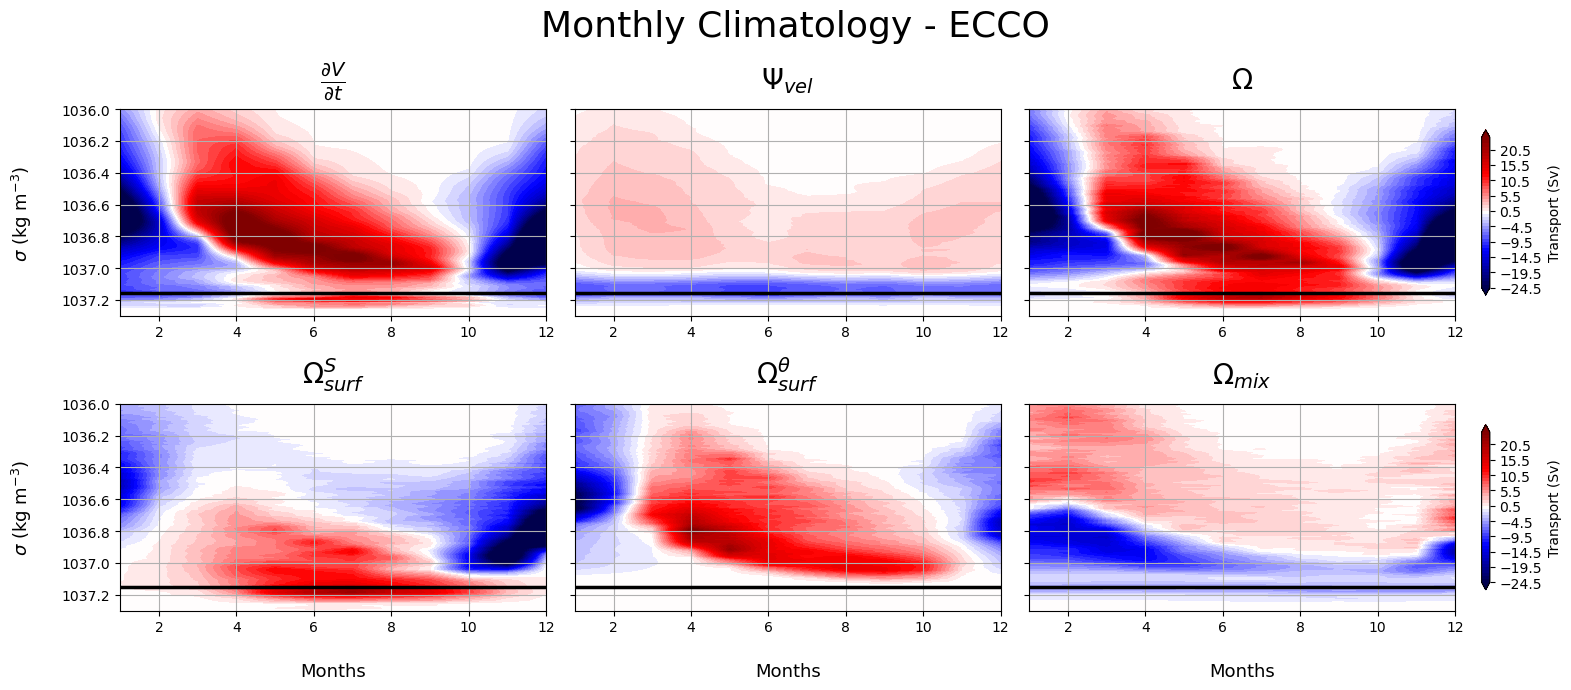

In [126]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt)
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin,
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036)
ax[0,0].axhline(y=1037.155, color='k', linewidth=2.5)

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax[0,1].grid()
ax[0,1].axhline(y=1037.155, color='k', linewidth=2.5)

omega_clim = (clim(clim_ds.omega_trans_rate) + clim(clim_ds.R2))
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Transport (Sv)', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].grid()
ax[0,2].axhline(y=1037.155, color='k', linewidth=2.5)

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].grid()
ax[1,0].axhline(y=1037.155, color='k', linewidth=2.5)

omega_surf_th_clim = clim(clim_ds.omega_surf_th)
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax[1,1].grid()
ax[1,1].axhline(y=1037.155, color='k', linewidth=2.5)

omega_mix__clim = clim(clim_ds.omega_mix)
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Transport (Sv)', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].grid()
ax[1,2].axhline(y=1037.155, color='k', linewidth=2.5)

plt.suptitle('Monthly Climatology - ECCO', fontsize=26)
plt.tight_layout()
plt.savefig('clim-pcolor-ecco.pdf', transparent=True);

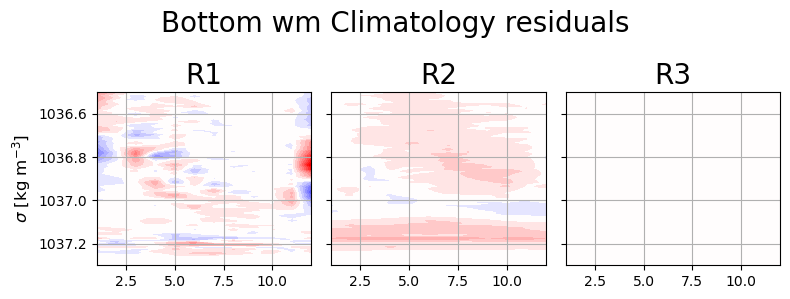

In [65]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1)
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin,
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title('R1', fontsize=20)
ax0.grid()
ax0.set_ylim(1037.3, 1036.5)

R2_clim = clim(clim_ds.R2)
c_psi = ax1.contourf(R2_clim.month, R2_clim.sigma2_bin, R2_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title('R2', fontsize=20)
ax1.grid()

R3_clim = clim(clim_ds.R3)
c_psi = ax2.contourf(R3_clim.month, R3_clim.sigma2_bin, R3_clim.T,
                         cmap='seismic', levels=levels, extend='both')
ax2.set_title('R3', fontsize=20)
ax2.grid()

plt.suptitle('Bottom wm Climatology residuals', fontsize=20)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [66]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=1037.155, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-10.049909  ,  -8.30838   ,  -8.632878  ,  -5.124162  ,
        -0.18515188,   3.4189048 ,   5.8406568 ,   3.9671383 ,
         0.74715656,  -1.4799502 ,  -5.881708  ,  -8.824965  ],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

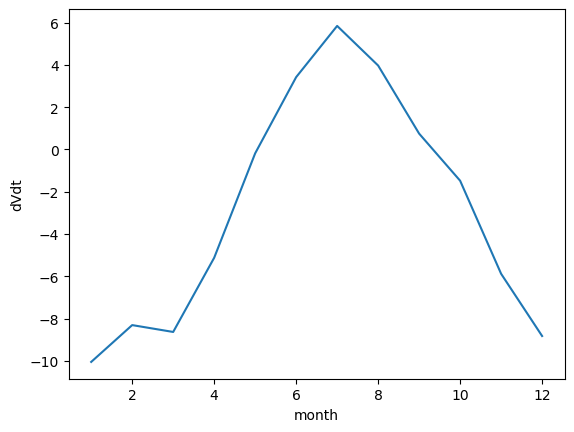

In [67]:
dVdt_clim_bot.plot();

### $\Psi$

In [68]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.sel(sigma2_bin=1037.155, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-8.805042 , -7.6023726, -7.4220176, -7.984308 , -8.669008 ,
       -8.898411 , -8.240739 , -7.177587 , -7.895185 , -6.7201204,
       -6.866942 , -7.556324 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

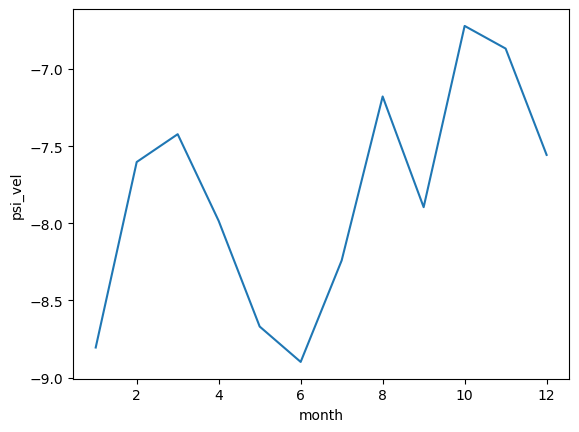

In [69]:
psi_clim_bot.plot();

### $\Omega$

In [70]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [71]:
omega_clim_bot = omega_clim.isel(sigma2_bin=-1) - omega_clim.sel(sigma2_bin=1037.155, method='nearest')
omega_clim_bot.load()

<xarray.DataArray (month: 12)>
array([  2.07012969,   1.52740667,   0.58665228,  -3.59918142,
       -10.30034728, -13.27005397, -13.79691874, -11.44827401,
        -9.32882201,  -5.20044076,  -0.57520629,   1.81407243])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [72]:
omega_bdy_clim_bot = clim(bdy_omegas[-3])
omega_bdy_clim_bot

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-3.7856634 , -3.31407417, -2.16522612,  1.9483032 ,  9.78287642,
       12.34626307, 13.57935611, 10.04309464,  7.82847437,  2.61422417,
       -2.39795928, -3.81700374])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

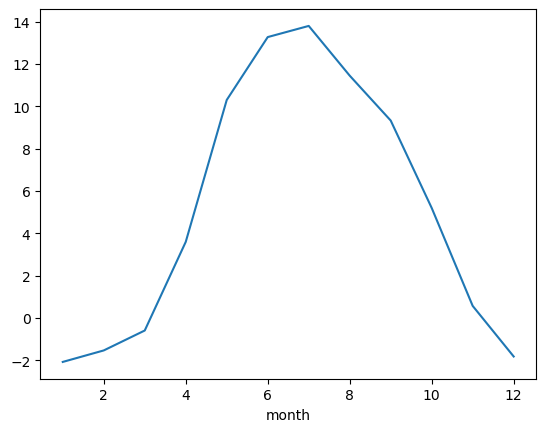

In [76]:
(-omega_clim_bot).plot();

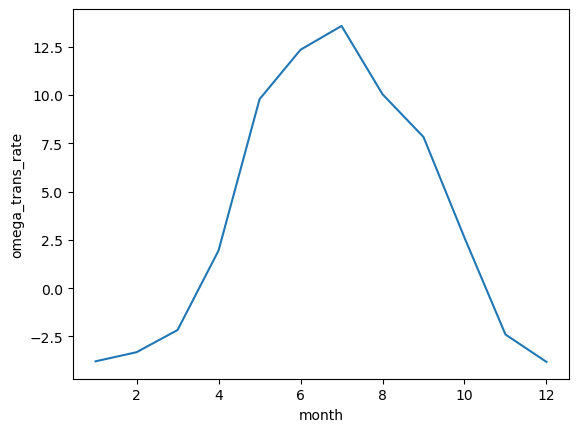

In [74]:
omega_bdy_clim_bot.plot();

### Residuals

In [79]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.sel(sigma2_bin=1037.155, method='nearest')
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.83435427,  0.86716323, -0.5566811 , -0.68232773, -1.75476404,
       -0.90770731,  0.34236611, -0.2661281 , -0.65327942,  0.04211678,
        0.39611052,  0.52528714])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [80]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.sel(sigma2_bin=1037.155, method='nearest')
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([1.59484254, 1.79876674, 1.61392072, 1.64777803, 1.33663468,
       1.70824032, 1.53160744, 1.40348501, 1.82420778, 1.96000983,
       1.99130989, 1.63982718])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [81]:
#remember we are switching signs!
R3_clim_bot = - R3_clim.isel(sigma2_bin=-1) + R3_clim.sel(sigma2_bin=1037.155, method='nearest')
R3_clim_bot.load()

<xarray.DataArray 'R3' (month: 12)>
array([-0.00909058, -0.0457642 , -0.06752679, -0.05670836, -0.06172692,
       -0.04503074, -0.05788922, -0.03742041, -0.03320067, -0.00238706,
        0.01391676,  0.02014508])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### __Bottom climatology budget__

In [82]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot + R3_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([  5.73510229,   4.85357992,   2.78722584,  -5.55058505,
       -19.26405976, -24.83186776, -26.0622305 , -21.4930633 ,
       -16.83343593,  -8.44087168,   0.84089709,   5.26797235])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [83]:
clim_budget1 = - dVdt_clim_bot + psi_clim_bot + omega_bdy_clim_bot + R1_clim_bot + R2_clim_bot + R3_clim_bot
clim_budget1

<xarray.DataArray (month: 12)>
array([-0.12069079,  0.01209908,  0.03534744, -0.00310043,  0.81916394,
        0.78444929,  1.31404434, -0.00169465,  0.32386045, -0.62620676,
       -0.9818559 , -0.36310382])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

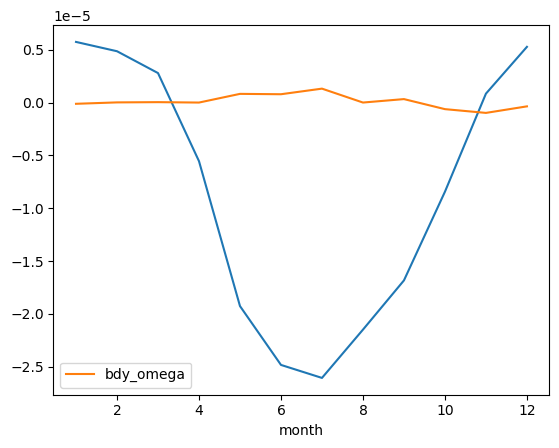

In [84]:
(clim_budget/1e6).plot()
(clim_budget1/1e6).plot(label='bdy_omega')
plt.legend()

In [85]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_bdy_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([-2.54079703, -2.60806668, -0.95436539, -0.91184236,  1.29902022,
        0.02894702, -0.50203999, -1.10163116, -0.81386724, -2.62594631,
       -3.38319306, -2.54836322])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

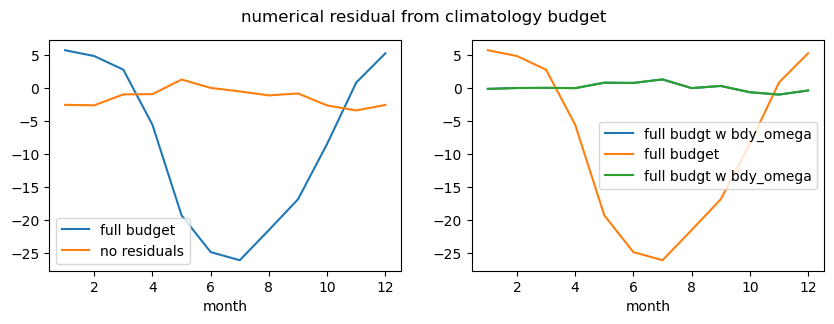

In [86]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_budget1.plot(ax=ax1, label='full budgt w bdy_omega')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')
ax0.legend()

clim_budget.plot(ax=ax1, label='full budget')
clim_budget1.plot(ax=ax1, label='full budgt w bdy_omega')


plt.legend()
plt.suptitle('numerical residual from climatology budget');

## BOTTOM Monthly Climatology

In [55]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [56]:
#1037.115 to include 1037.125 when slicing
anom_ds = (wmt_budget_terms/1e6)#.sel(sigma2_bin=slice(1037.115, 1037.5)))/1e6

In [57]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [58]:
clim_ds = wmt_no_polynya/1e6#.sel(sigma2_bin=slice(1037.115, 1037.5)) / 1e6

In [59]:
clim_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 999, time: 240)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/25)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_slt                (time, sigma2_bin) float64 0.07888 0.07888 ... 0.0 0.0
    R2_th                 (time, sigma2_bin) float64 0.07888 0.07888 ... 0.0 0.0
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_slt           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv_th            (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

In [87]:
clim_ecco = xr.merge([dVdt_clim.rename('dVdt_clim'), psi_vel_clim.rename('psi_vel_clim'), 
                      omega_clim.rename('omega_clim'), omega_mix__clim.rename('omega_mix__clim'), 
                      omega_surf_slt_clim.rename('omega_surf_slt_clim'), omega_surf_th_clim.rename('omega_surf_th_clim'),
                      R1_clim.rename('R1_clim'), R2_clim.rename('R2_clim'), R3_clim.rename('R3_clim')])
clim_ecco

<xarray.Dataset>
Dimensions:              (sigma2_bin: 999, month: 12)
Coordinates:
  * sigma2_bin           (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * month                (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt_clim            (month, sigma2_bin) float32 0.00557 ... -0.002153
    psi_vel_clim         (month, sigma2_bin) float32 -0.07987 -0.07987 ... 0.0
    omega_clim           (month, sigma2_bin) float64 0.07987 ... -0.001756
    omega_mix__clim      (month, sigma2_bin) float64 0.0 0.0 ... -0.00205
    omega_surf_slt_clim  (month, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0
    omega_surf_th_clim   (month, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R1_clim              (month, sigma2_bin) float64 0.00557 ... -0.0001103
    R2_clim              (month, sigma2_bin) float64 0.07987 ... 0.0002944
    R3_clim              (month, sigma2_bin) float64 0.0 0.0 ... -0.0002867

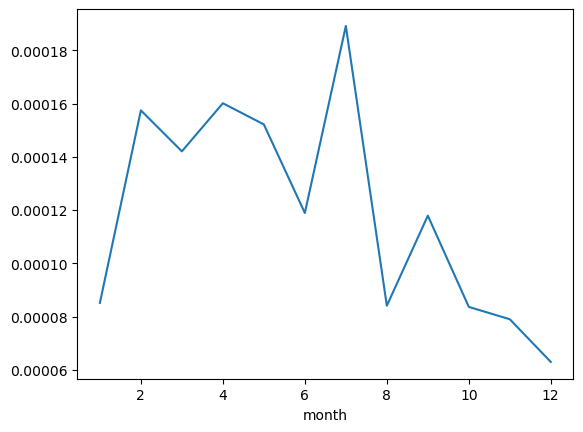

In [88]:
((- clim_ecco.dVdt_clim + clim_ecco.psi_vel_clim + 
      clim_ecco.omega_clim + clim_ecco.R1_clim +
     clim_ecco.R2_clim + clim_ecco.R3_clim).sum('sigma2_bin')/1e6).plot()

In [89]:
#save as netcdf to stack with sose & soda in stacked figs dir
clim_ecco.to_netcdf('clim_ecco', mode='w')

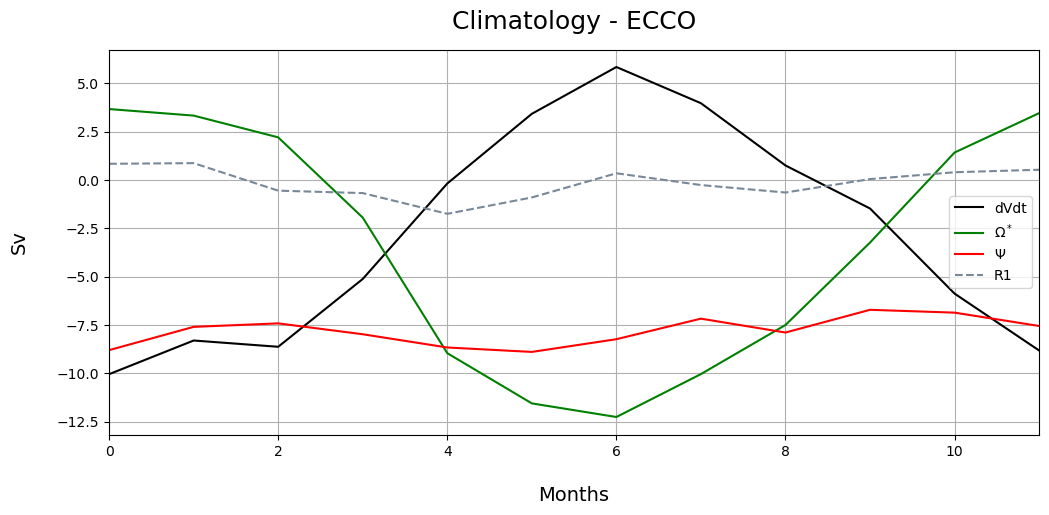

In [90]:
plt.figure(figsize=(12,5))
plt.plot(dVdt_clim_bot, label='dVdt', color='k')
plt.plot((omega_clim_bot+R2_clim_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_clim_bot, label=r'$\Psi$', color='red')
plt.plot(R1_clim_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title('Climatology - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)

plt.legend()
plt.grid();

In [76]:
omega_bdy_clim_bot

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-3.82368675, -3.33893305, -2.57911531,  1.21917652,  8.41466079,
       10.41881745, 11.24166637,  8.50992813,  6.54741223,  1.81495926,
       -2.4800388 , -3.83912888])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [91]:
omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
omega_surf_th_clim = clim(clim_ds.omega_surf_th)
omega_mix_clim = clim(clim_ds.omega_mix)

In [98]:
omega_surf_slt_clim_bot = -(omega_surf_slt_clim.isel(sigma2_bin=-1) - 
                          omega_surf_slt_clim.sel(sigma2_bin=1037.155, method='nearest'))
omega_surf_th_clim_bot = -(omega_surf_th_clim.isel(sigma2_bin=-1) - 
                          omega_surf_th_clim.sel(sigma2_bin=1037.155, method='nearest'))
omega_mix_clim_bot = -(omega_mix_clim.isel(sigma2_bin=-1) - 
                          omega_mix_clim.sel(sigma2_bin=1037.155, method='nearest'))

In [99]:
omega_clim_bot = - omega_clim.isel(sigma2_bin=-1) + omega_clim.sel(sigma2_bin=1037.155, method='nearest')
omega_clim_bot.load()

<xarray.DataArray (month: 12)>
array([-2.07012969, -1.52740667, -0.58665228,  3.59918142, 10.30034728,
       13.27005397, 13.79691874, 11.44827401,  9.32882201,  5.20044076,
        0.57520629, -1.81407243])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

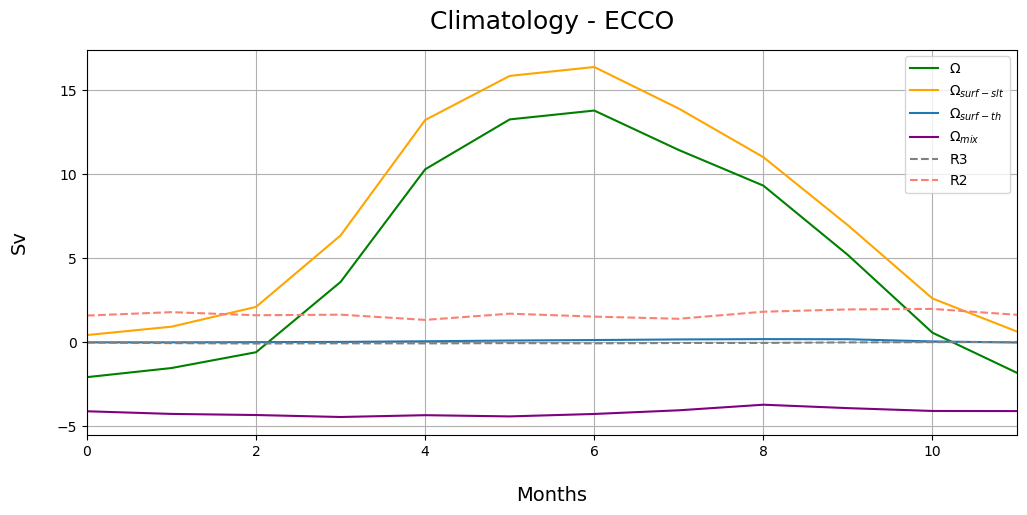

In [105]:
plt.figure(figsize=(12,5))
plt.plot(omega_clim_bot, label=r'$\Omega$', color='green')
#plt.plot(omega_bdy_clim_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_clim_bot, label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_clim_bot, label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_clim_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R3_clim_bot, label='R3', color='grey', linestyle='--')
plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title('Climatology - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)
plt.grid()
plt.legend();

In [101]:
omega_clim_bot.mean('month')

<xarray.DataArray ()>
array(5.12674862)

In [103]:
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot ).mean('month')

<xarray.DataArray ()>
array(3.45586277)

In [106]:
(-omega_clim_bot + omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot ).mean('month')

<xarray.DataArray ()>
array(-1.67088585)

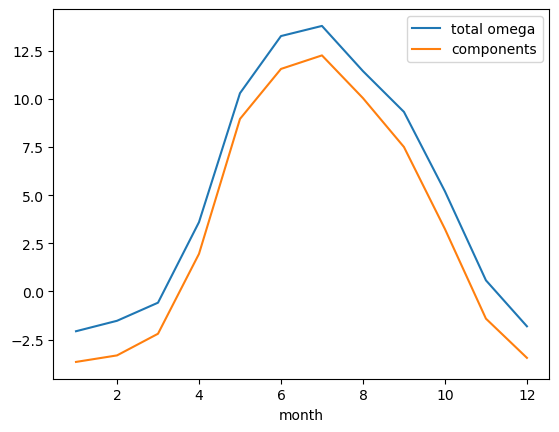

In [104]:
omega_clim_bot.plot(label='total omega')
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).plot(label='components')

plt.legend();

## Anomaly

In [111]:
import warnings
warnings.filterwarnings("ignore")

In [112]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

In [113]:
clim_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 999, time: 240)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_slt                (time, sigma2_bin) float64 0.07888 0.07888 ... 0.0 0.0
    R2_th                 (time, sigma2_bin) float64 0.07888 0.07888 ... 0.0 0.0
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_slt           (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv_th            (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

In [119]:
#bot_wm = wmt_budget_terms.sel(sigma2_bin=slice(1036.495, 1037.5)) / 1e6
anom_unrolled = wmt_budget_terms.groupby('time.month') - clim(clim_ds)
anom_sv = anom_unrolled / 1e6
anom_before_drop = anom_sv.rolling(time=12, center=True).mean(dim='time')
anom = anom_before_drop.drop(['time_snp', 'month'])

In [120]:
anom

<xarray.Dataset>
Dimensions:               (sigma2_bin: 999, time: 288)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2_th                 (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R3_slt                (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_slt           (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv_th            (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

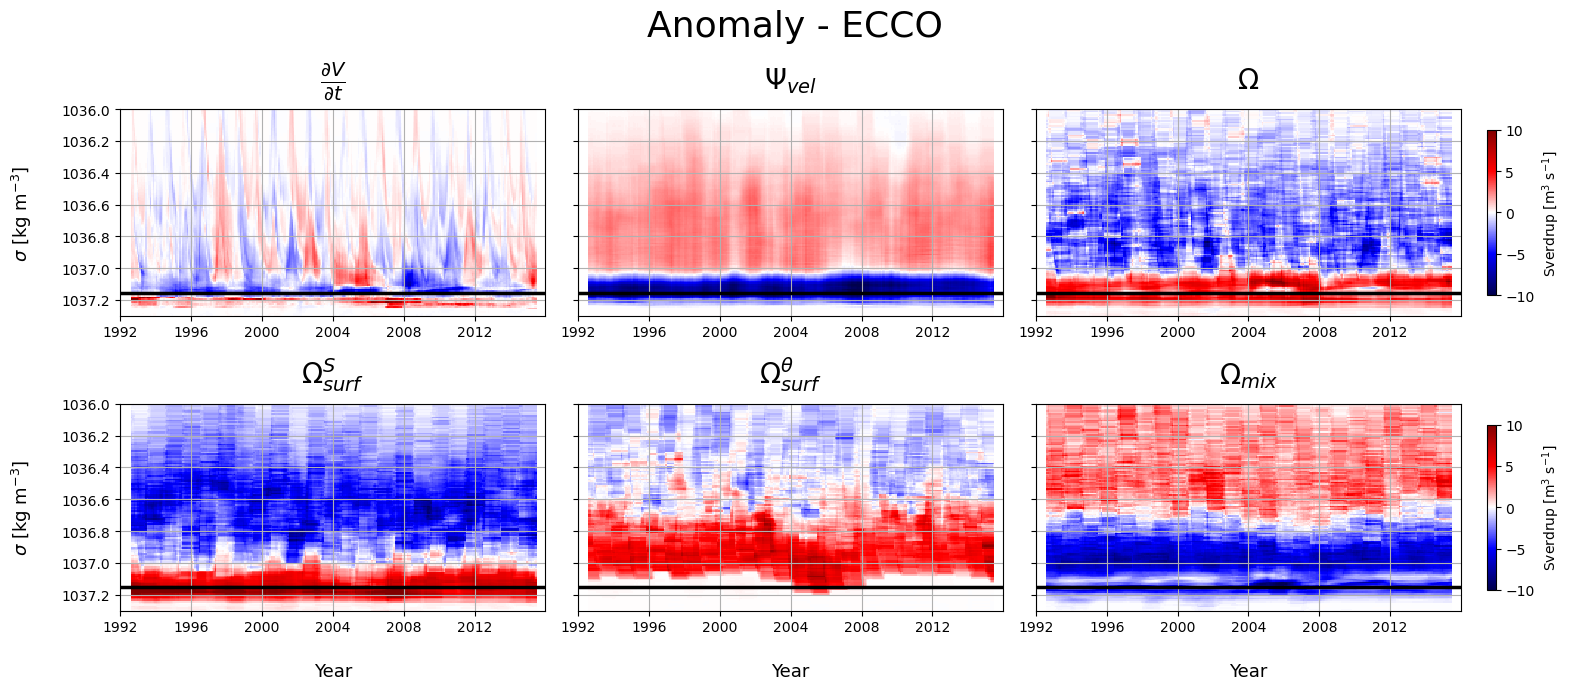

In [128]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036)
ax[0,0].axhline(y=1037.155, color='k', linewidth=2.5)

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()
ax[0,1].axhline(y=1037.155, color='k', linewidth=2.5)

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()
ax[0,2].axhline(y=1037.155, color='k', linewidth=2.5)

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()
ax[1,0].axhline(y=1037.155, color='k', linewidth=2.5)

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()
ax[1,1].axhline(y=1037.155, color='k', linewidth=2.5)

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()
ax[1,2].axhline(y=1037.155, color='k', linewidth=2.5)

plt.suptitle('Anomaly - ECCO', fontsize=26)
plt.tight_layout()
plt.savefig('anom-pcolor-ecco.pdf', transparent=True);

In [129]:
anom_bot = - anom.isel(sigma2_bin=-1) + anom.sel(sigma2_bin=1037.155, method='nearest')
anom_bot

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/24)
    R1                    (time) float64 nan nan nan nan nan ... nan nan nan nan
    R2                    (time) float64 nan nan nan nan nan ... nan nan nan nan
    R2_slt                (time) float64 nan nan nan nan nan ... nan nan nan nan
    R2_th                 (time) float64 nan nan nan nan nan ... nan nan nan nan
    R3                    (time) float64 nan nan nan nan nan ... nan nan nan nan
    R3_slt                (time) float64 nan nan nan nan nan ... nan nan nan nan
    ...                    ...
    omega_trans_rate_slt  (time) float64 nan nan nan nan nan ... nan nan nan nan
    omega_trans_rate_th   (time) float64 nan nan nan nan nan ... nan nan nan nan
    psi_adv               (time) float64 nan nan nan nan nan ... nan nan nan nan
    psi_adv_slt           (time) float64 nan nan nan nan nan ... nan nan nan nan
    psi_adv_th            (time) float64 nan nan nan nan nan ... nan nan nan nan
    psi_vel               (time) float32 nan nan nan nan nan ... nan nan nan nan

In [130]:
#save so can use for anom plot in stacked-figs dir
anom.to_netcdf('anom_ecco')

### $\frac{\partial V}{\partial t}$

In [131]:
dVdt_anom_bot = anom_bot.dVdt
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan, -2.414014  , -2.2653525 , -1.7513337 ,
       -1.5824596 , -1.7962672 , -1.5847223 , -1.9972003 , -3.0684097 ,
       -2.7001424 , -2.3261402 , -1.8949478 , -1.2649469 , -0.68116605,
       -0.24559574,  0.15755343,  0.32525915,  0.47891086, -0.20391503,
       -0.2688292 , -0.21761563, -0.9996518 , -0.9148631 , -1.1369025 ,
       -0.98610115, -1.1661866 , -1.690959  , -2.2247431 , -2.329894  ,
       -2.6099596 , -2.1239038 , -2.887865  , -2.5179112 , -2.220616  ,
       -3.028341  , -2.5787392 , -2.7338166 , -2.6942594 , -2.4935277 ,
       -2.57896   , -2.4538202 , -2.7324715 , -3.2391737 , -3.1333392 ,
       -3.9104629 , -4.477367  , -4.4608636 , -5.0138903 , -5.8338428 ,
       -6.5470276 , -6.551363  , -6.722831  , -7.392712  , -7.776066  ,
       -7.7358136 , -7.6533613 , -7.785922  , -7.2312355 , -7.216764  ,
       -6.916768  , -6.6751657 , -6.498978  , -6.90557   , -6.75701   ,
       -6.031065  , -5.114927  , -4.6893315 , -4.299837  , -3.692331  ,
       -3.483196  , -3.2739666 , -3.2193627 , -2.3992102 , -2.0358725 ,
       -1.6105268 , -1.3912737 , -1.8731873 , -2.632842  , -3.9856348 ,
       -4.373429  , -4.5309353 , -4.3390427 , -4.381074  , -4.1085305 ,
       -4.558529  , -4.4258966 , -4.585087  , -4.9774904 , -4.595239  ,
       -4.4216084 , -3.605202  , -3.6732717 , -3.4669507 , -3.9117541 ,
...
       -2.2838151 , -3.3264613 , -3.8681998 , -4.686448  , -4.754533  ,
       -5.7993116 , -5.388667  , -4.8724394 , -4.630737  , -4.2185225 ,
       -3.5508392 , -3.2375445 , -3.2505243 , -3.7427497 , -3.8111014 ,
       -3.4761248 , -3.5680957 , -3.4387798 , -3.280462  , -3.5510721 ,
       -3.4461393 , -3.52752   , -3.6048594 , -3.4158735 , -2.854113  ,
       -2.386242  , -2.6245403 , -2.7236269 , -2.6406763 , -2.8597121 ,
       -2.9370837 , -3.033777  , -2.806005  , -2.8712163 , -2.9144907 ,
       -3.6641872 , -3.622106  , -3.4448795 , -3.4369743 , -3.064281  ,
       -2.5216439 , -1.9054092 , -1.2488528 , -1.3234528 , -1.703429  ,
       -1.6798767 , -1.7680187 , -1.4634098 , -1.6672564 , -1.7870555 ,
       -1.2323027 , -1.831866  , -2.2251718 , -2.1947243 , -2.6500344 ,
       -2.971943  , -3.3654828 , -3.377142  , -3.280382  , -3.1165185 ,
       -3.3096635 , -3.050121  , -3.2519999 , -3.0097291 , -3.164606  ,
       -3.4847887 , -3.4777732 , -3.2181404 , -3.046259  , -2.8285427 ,
       -2.8208494 , -2.6795025 , -2.1305492 , -2.771304  , -2.8827326 ,
       -2.7887    , -2.7438674 , -2.445941  , -2.4958234 , -2.0433218 ,
       -1.1836814 , -1.5499653 , -1.2379075 , -1.4214481 , -1.3269986 ,
       -0.7594061 , -0.6939594 , -0.08066113,  0.20491515,  0.31585595,
        0.23357837, -0.10027444,         nan,         nan,         nan,
               nan,         nan,         nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

### $\Psi$

In [132]:
psi_anom_bot = anom_bot.psi_vel
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,  -8.66648  ,  -8.737757 ,  -8.920366 ,
        -8.883444 ,  -8.8292885,  -8.591076 ,  -8.609056 ,  -8.828074 ,
        -8.8324585,  -8.665557 ,  -8.777103 ,  -8.659313 ,  -8.372333 ,
        -8.39343  ,  -8.188364 ,  -8.3415785,  -8.418607 ,  -8.791319 ,
        -8.798565 ,  -8.840302 ,  -9.004766 ,  -9.10421  ,  -9.240843 ,
        -9.2865715,  -9.398106 ,  -9.371889 ,  -9.493342 ,  -9.431072 ,
        -9.586521 ,  -9.269905 ,  -9.670756 ,  -9.499568 ,  -9.325396 ,
        -9.434269 ,  -8.9710655,  -8.839523 ,  -8.829532 ,  -8.766291 ,
        -8.590455 ,  -8.441996 ,  -8.321318 ,  -8.637872 ,  -8.145393 ,
        -8.161222 ,  -8.462936 ,  -8.169655 ,  -8.243769 ,  -8.265148 ,
        -8.283046 ,  -8.271109 ,  -8.217807 ,  -8.158268 ,  -8.063637 ,
        -8.012406 ,  -8.084827 ,  -8.014711 ,  -7.51548  ,  -7.908618 ,
        -7.899835 ,  -8.098352 ,  -8.035374 ,  -7.94938  ,  -8.177772 ,
        -8.071151 ,  -8.077221 ,  -7.850877 ,  -7.7854934,  -7.9117613,
        -8.182217 ,  -8.125113 ,  -8.449099 ,  -8.186591 ,  -8.282649 ,
        -8.567161 ,  -8.724966 ,  -8.919152 ,  -9.076977 ,  -9.464691 ,
        -9.71691  ,  -9.483401 ,  -9.4441   ,  -9.270386 ,  -8.9759   ,
        -8.890293 ,  -8.521448 ,  -8.393901 ,  -8.420299 ,  -8.579011 ,
        -8.4544735,  -8.243467 ,  -8.378587 ,  -8.5731735,  -8.778465 ,
...
        -9.937391 ,  -9.832476 ,  -9.626898 ,  -9.432945 ,  -8.970991 ,
        -8.713556 ,  -8.547034 ,  -8.045129 ,  -7.737606 ,  -7.5952506,
        -7.360496 ,  -7.5017166,  -7.5163527,  -7.336913 ,  -7.2243476,
        -6.932187 ,  -7.552093 ,  -7.70687  ,  -7.4913435,  -7.7095013,
        -7.9368944,  -8.330454 ,  -8.514543 ,  -8.185387 ,  -7.9092994,
        -7.821277 ,  -8.081366 ,  -8.112745 ,  -7.605301 ,  -7.275739 ,
        -7.4519763,  -7.502206 ,  -7.355015 ,  -7.032434 ,  -6.611042 ,
        -6.788247 ,  -6.5547104,  -6.5170035,  -6.4541526,  -6.5047946,
        -6.5169134,  -6.7731667,  -6.5158153,  -6.5408325,  -6.5129023,
        -6.435954 ,  -6.4036098,  -6.3149433,  -6.6852827,  -6.9259214,
        -6.629548 ,  -6.8131247,  -6.669977 ,  -6.275466 ,  -6.2831435,
        -6.240146 ,  -6.328695 ,  -6.421111 ,  -6.547077 ,  -6.481201 ,
        -6.4869432,  -6.140874 ,  -6.3861074,  -6.169502 ,  -6.3095775,
        -6.3735976,  -6.4549103,  -6.4017005,  -6.290864 ,  -6.369812 ,
        -6.4787874,  -6.5278163,  -6.221353 ,  -6.378847 ,  -6.2295   ,
        -6.1411133,  -6.1905246,  -6.3361263,  -6.2380705,  -5.8401833,
        -5.9020476,  -5.8457117,  -5.5611086,  -5.4839706,  -5.526649 ,
        -5.3472633,  -5.380069 ,  -5.118832 ,  -4.9466987,  -4.6275954,
        -4.904746 ,  -5.2850513,         nan,         nan,         nan,
               nan,         nan,         nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

### $\Omega$

In [133]:
omega_anom_bot = anom_bot.omega_trans_rate

In [134]:
omega_surf_slt_anom_bot = anom_bot.omega_surf_slt
omega_surf_th_anom_bot = anom_bot.omega_surf_th
omega_mix_anom_bot = anom_bot.omega_mix

### Residuals

In [135]:
R1_anom_bot = anom_bot.R1

In [136]:
R2_anom_bot = anom_bot.R2

### __Bottom anomaly budget__

In [137]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).mean('time')

<xarray.DataArray ()>
array(0.02757728)

In [138]:
anom_budget = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot
anom_budget

<xarray.DataArray (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.04233344,  0.04452728,  0.03985953,
        0.0412686 ,  0.04102062,  0.04226734,  0.03966414,  0.04038016,
        0.0429637 ,  0.03958651,  0.03593119,  0.03466271,  0.03087137,
        0.02929647,  0.03207187,  0.03437486,  0.0329866 ,  0.03119775,
        0.03169416,  0.03113115,  0.02920004,  0.03415361,  0.03690501,
        0.03719464,  0.03604797,  0.03574942,  0.03454106,  0.0327503 ,
        0.03639251,  0.03886068,  0.03731615,  0.03964854,  0.04354675,
        0.0395847 ,  0.03805295,  0.03704461,  0.03976665,  0.03936748,
        0.04163276,  0.04309844,  0.03958811,  0.03919078,  0.04010629,
        0.03823067,  0.03806719,  0.03597849,  0.03221395,  0.03312387,
        0.03249207,  0.03354846,  0.03443045,  0.02918837,  0.03498626,
        0.03302542,  0.03253284,  0.02827607,  0.03347804,  0.03735524,
        0.04002526,  0.03894583,  0.03581583,  0.03297427,  0.02692313,
        0.02978904,  0.02547893,  0.02555293,  0.02327387,  0.0268858 ,
        0.02174834,  0.018505  ,  0.0183124 ,  0.01653775,  0.0188881 ,
        0.01831439,  0.02239699,  0.02293269,  0.023097  ,  0.02474834,
        0.02884381,  0.03225963,  0.03365116,  0.03518634,  0.03430472,
        0.03509962,  0.03502265,  0.03842946,  0.04067516,  0.0387211 ,
        0.0383922 ,  0.03926415,  0.03869911,  0.03639707,  0.03663384,
...
        0.02660305,  0.02332208,  0.03128946,  0.0335261 ,  0.03233082,
        0.03598691,  0.03718035,  0.03349741,  0.03334101,  0.03148865,
        0.02968969,  0.02586493,  0.02996673,  0.02840036,  0.02701751,
        0.02762244,  0.03006754,  0.02748751,  0.02470589,  0.02302648,
        0.02548036,  0.02731402,  0.02792191,  0.02927741,  0.02826738,
        0.0275278 ,  0.02509934,  0.02804289,  0.02678571,  0.02794552,
        0.0298336 ,  0.02993362,  0.02691657,  0.02731158,  0.02716526,
        0.02600485,  0.02463882,  0.0266248 ,  0.02598085,  0.02658533,
        0.02987419,  0.02961789,  0.02626392,  0.026809  ,  0.03153671,
        0.03074974,  0.02982947,  0.03273402,  0.03500674,  0.03797584,
        0.03303382,  0.0276158 ,  0.02708414,  0.03623755,  0.03884668,
        0.03829642,  0.03475088,  0.0352146 ,  0.03743568,  0.0383652 ,
        0.03105874,  0.03072557,  0.02879064,  0.03164304,  0.02794964,
        0.02387455,  0.02623846,  0.02751928,  0.02745681,  0.02763102,
        0.02721197,  0.02190193,  0.02953393,  0.02858416,  0.0370005 ,
        0.03865116,  0.04304272,  0.04117833,  0.03268512,  0.0275843 ,
        0.02912447,  0.02734827,  0.02885857,  0.0317807 ,  0.02951211,
        0.03016368,  0.02915915,  0.02486901,  0.021888  ,  0.02072306,
        0.02692787,  0.02929619,         nan,         nan,         nan,
               nan,         nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [139]:
anom_bdgt_nores = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot
anom_bdgt_nores

<xarray.DataArray (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.72185739, -0.8061989 , -1.36302567,
       -1.5753431 , -1.2683608 , -1.58493289, -1.61207154, -1.29128624,
       -1.06118102, -1.04750573, -1.50503196, -1.79877306, -1.82083983,
       -1.98569246, -2.02951955, -1.86372634, -1.78933169, -1.47413779,
       -1.24874024, -1.40953934, -1.38995322, -1.52021786, -1.43358339,
       -1.64929243, -1.68523474, -1.24341386, -1.06800068, -1.46524779,
       -1.55972171, -1.91603154, -1.95477432, -1.9205594 , -1.77133726,
       -1.55361266, -1.69837881, -1.61783297, -1.90460759, -2.2216685 ,
       -1.98560556, -1.67118101, -1.29379196, -1.17276635, -1.32628903,
       -1.37486661, -1.78030207, -1.7656053 , -1.60632264, -0.98064265,
       -0.23534605, -0.22523164,  0.04403276,  0.44406334,  0.6472059 ,
        0.75203041,  0.84601236,  1.02656461,  1.25769504,  1.26370052,
        1.21303347,  0.84467506,  0.70682755,  1.23407813,  0.8817243 ,
        0.5833128 , -0.03684062, -0.41709403, -0.7581593 , -1.14362663,
       -1.29808374, -1.51257534, -1.73846049, -2.14507032, -2.47456492,
       -3.12712083, -3.6147741 , -3.59591521, -3.24398188, -2.64896184,
       -2.70943279, -2.42124558, -2.5651548 , -2.48494953, -2.63116651,
       -2.14600552, -2.06348507, -1.84594732, -1.25150053, -1.52617737,
       -1.20190226, -1.55278478, -1.42187727, -1.62323281, -1.58286774,
...
       -2.07223204, -1.81438637, -1.29882103, -1.17566237, -0.68422434,
       -0.1649076 , -0.26222135, -0.3589791 , -0.28415053, -0.43003715,
       -0.92744846, -1.63685714, -1.83902633, -1.12477582, -1.30508869,
       -1.15923346, -1.3362506 , -1.43064421, -1.62974512, -1.58008015,
       -1.9262385 , -2.16416796, -2.09645377, -1.70517321, -2.0536812 ,
       -2.35926663, -2.45753715, -2.36309728, -2.37037273, -2.07278941,
       -2.00668176, -1.87096608, -1.81269596, -1.38157013, -0.96279446,
       -0.53325892, -0.46931959, -0.888959  , -0.84213644, -1.03301284,
       -0.95468307, -1.3734756 , -1.69499685, -1.74574324, -1.50508086,
       -1.62055095, -1.61501553, -1.92049972, -1.80775815, -1.72292508,
       -1.69058429, -1.54854626, -1.51470088, -1.36303622, -0.85610315,
       -0.55187833, -0.24781184, -0.29767086, -0.51756857, -0.62712683,
       -0.41424734, -0.18696211, -0.35664785, -0.55421565, -0.68219158,
       -0.47712584, -0.51116578, -0.69353774, -0.77032073, -1.0625902 ,
       -1.14403116, -1.29931328, -1.51533733, -1.27240865, -0.77778697,
       -0.57585275, -0.4186452 , -0.84639398, -0.78451009, -0.78698556,
       -1.64783388, -1.25948848, -1.22984629, -0.84813488, -0.64166301,
       -0.71270429, -1.00143696, -1.44526851, -1.72664373, -1.53337857,
       -1.89839687, -1.97470443,         nan,         nan,         nan,
               nan,         nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

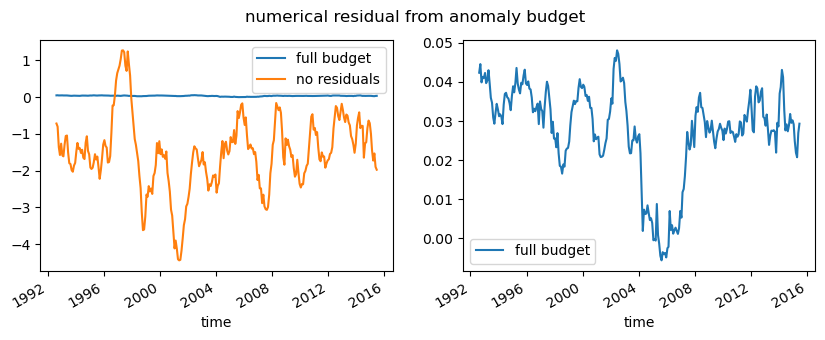

In [142]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
anom_budget.plot(ax=ax0, label='full budget')
anom_bdgt_nores.plot(ax=ax0, label='no residuals')
ax0.legend()

anom_budget.plot(ax=ax1, label='full budget')

ax1.legend()
plt.suptitle('numerical residual from anomaly budget');

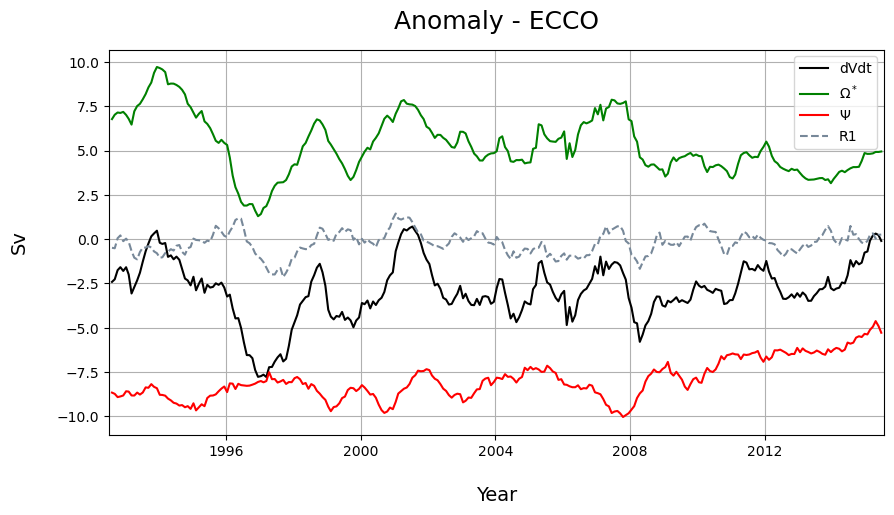

In [145]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title('Anomaly - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[6], dVdt_anom_bot.time[-6]) #1992-07 to 2015-07

plt.legend()
plt.grid();

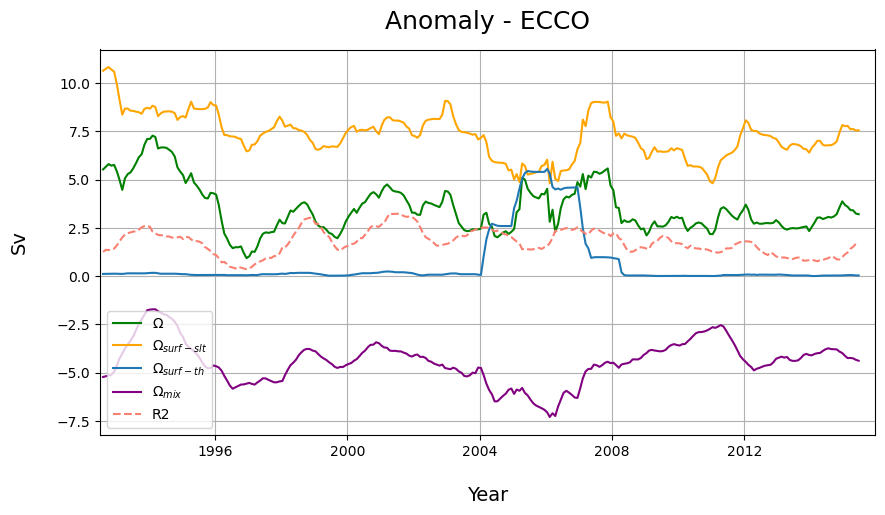

In [146]:
fig = plt.subplots(figsize=(10,5))
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, 
         label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, 
         label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, 
         label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title('Anomaly - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[6], dVdt_anom_bot.time[-1]) #1993-2015

plt.legend()
plt.grid();

## Indices

In [148]:
indices

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k                (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    enso             (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    fw_flx           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    heat_flx         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sam              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    windstress_curl  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ecco_si_index    (time) float32 -1.226 -0.5114 0.5835 ... 0.6039 -3.058

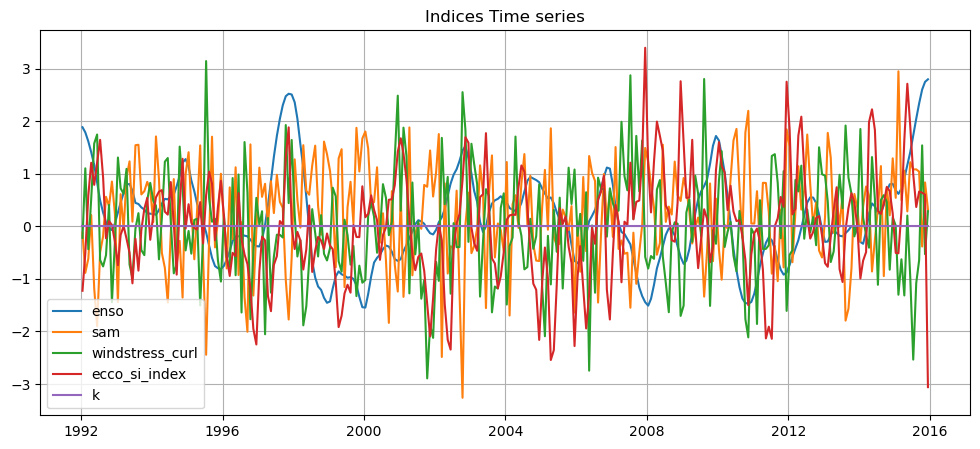

In [150]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.drop('month').variables:
    if i =='time':
        continue
    if i=='fw_flx':
        continue
    if i=='heat_flx':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [151]:
import seaborn as sn

In [154]:
indices_df = indices.drop(('month', 'k')).to_dataframe()
indices_df.head()

enso    fw_flx  heat_flx       sam  windstress_curl  \
time                                                                  
1992-01-15  1.883747 -1.300427  0.001594 -0.122525        -0.219413   
1992-02-13  1.786449 -0.869125 -0.867469 -0.885817         1.102549   
1992-03-15  1.614739 -2.230632 -1.918516 -0.616002        -0.435378   
1992-04-14  1.408937 -0.181473  0.300216  0.213964         0.524290   
1992-05-15  1.166296 -0.546701  0.713055 -1.179878         1.575049   

            ecco_si_index  
time                       
1992-01-15      -1.225907  
1992-02-13      -0.511387  
1992-03-15       0.583491  
1992-04-14       1.208238  
1992-05-15       0.788264

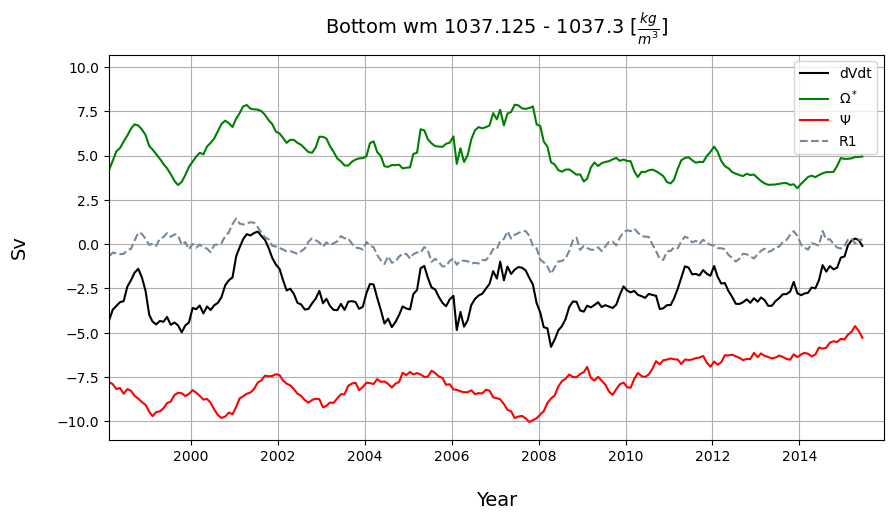

In [155]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

In [157]:
omega_star = omega_anom_bot + R2_anom_bot

In [161]:
ds = xr.merge([dVdt_anom_bot.rename('dvdt'), psi_anom_bot.rename('psi'), omega_star.rename('omega*')])
ds

<xarray.Dataset>
Dimensions:  (time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    dvdt     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    psi      (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    omega*   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [163]:
ds_omega = xr.merge([omega_anom_bot.rename('omega'), omega_mix_anom_bot.rename('mix'),
                     omega_surf_slt_anom_bot.rename('surf_slt'), omega_surf_th_anom_bot.rename('surf_th')])

In [164]:
omega_df = ds_omega.to_dataframe()

In [165]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [166]:
indices.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [114]:
budget_df = ds.to_dataframe()

In [115]:
budget_df.tail()

dvdt       psi    omega*
time                                    
2015-08-15  1.490057  0.885958 -0.119296
2015-09-14  2.737592  1.610785  0.321022
2015-10-15  2.211281  1.473193  0.155614
2015-11-14  2.196468  1.436117  0.133656
2015-12-14       NaN       NaN       NaN

### Correlation matrix of all terms (budget & indices)

In [116]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.tail()

dvdt       psi    omega*      ecco      enso    fw_flx  \
time                                                                     
2015-08-15  1.490057  0.885958 -0.119296  0.559372  2.045500  0.225318   
2015-09-14  2.737592  1.610785  0.321022  0.380170  2.336527 -0.677235   
2015-10-15  2.211281  1.473193  0.155614  0.957576  2.599419  0.302553   
2015-11-14  2.196468  1.436117  0.133656  0.743491  2.746488  0.399466   
2015-12-14       NaN       NaN       NaN -2.925005  2.794896  1.555206   

            heat_flx       sam  windstress_curl  
time                                             
2015-08-15 -0.579957  1.083196        -1.076998  
2015-09-14 -0.413434  1.039752        -0.643988  
2015-10-15 -0.738937 -0.384399         1.538923  
2015-11-14 -0.144605  0.833789        -0.529735  
2015-12-14  5.150780  0.318706         0.287670

In [125]:
omega_ind = pd.concat([omega_df, indices_df], axis=1)
omega_ind.head()

omega  mix  surf_slt  surf_th      ecco      enso    fw_flx  \
time                                                                      
1992-01-15    NaN  NaN       NaN      NaN -1.170194  1.883747 -1.300427   
1992-02-13    NaN  NaN       NaN      NaN -0.488146  1.786449 -0.869125   
1992-03-15    NaN  NaN       NaN      NaN  0.556974  1.614739 -2.230632   
1992-04-14    NaN  NaN       NaN      NaN  1.153485  1.408937 -0.181473   
1992-05-15    NaN  NaN       NaN      NaN  0.758463  1.166296 -0.546701   

            heat_flx       sam  windstress_curl  
time                                             
1992-01-15  0.001594 -0.122525        -0.219413  
1992-02-13 -0.867469 -0.885817         1.102549  
1992-03-15 -1.918516 -0.616002        -0.435378  
1992-04-14  0.300216  0.213964         0.524290  
1992-05-15  0.713055 -1.179878         1.575049

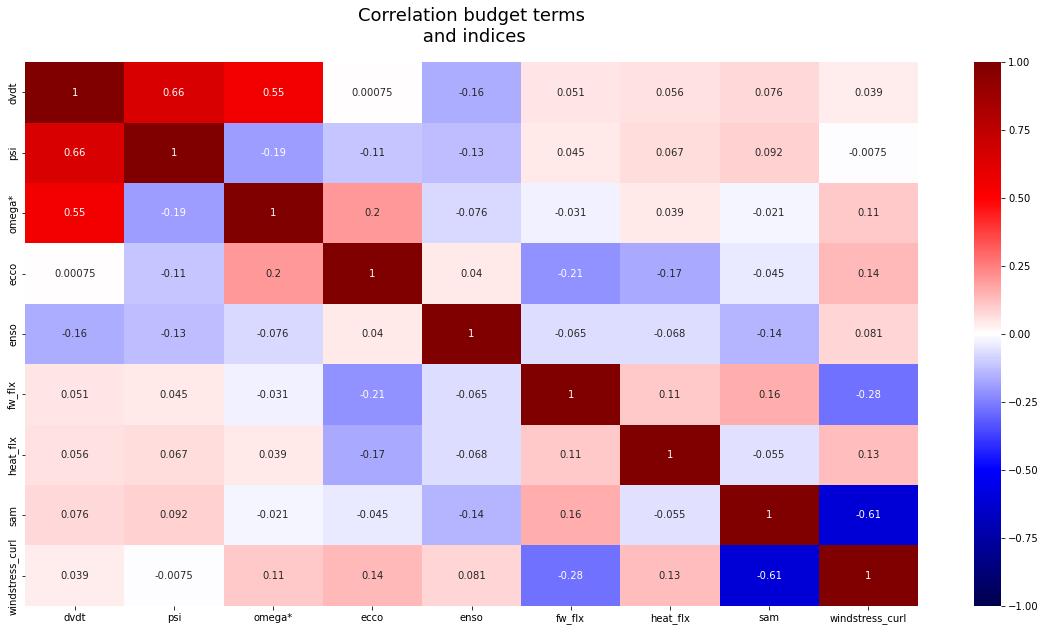

In [117]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);

In [118]:
corr = budget_ind.corr()
corr

dvdt       psi    omega*      ecco      enso    fw_flx  \
dvdt             1.000000  0.655327  0.551419  0.000755 -0.157868  0.051062   
psi              0.655327  1.000000 -0.190677 -0.113987 -0.125978  0.045498   
omega*           0.551419 -0.190677  1.000000  0.200544 -0.075979 -0.030702   
ecco             0.000755 -0.113987  0.200544  1.000000  0.040300 -0.211307   
enso            -0.157868 -0.125978 -0.075979  0.040300  1.000000 -0.064801   
fw_flx           0.051062  0.045498 -0.030702 -0.211307 -0.064801  1.000000   
heat_flx         0.055594  0.066887  0.039172 -0.165878 -0.068467  0.105556   
sam              0.075594  0.091525 -0.021122 -0.045092 -0.142116  0.159329   
windstress_curl  0.038536 -0.007549  0.108266  0.140075  0.081242 -0.277577   

                 heat_flx       sam  windstress_curl  
dvdt             0.055594  0.075594         0.038536  
psi              0.066887  0.091525        -0.007549  
omega*           0.039172 -0.021122         0.108266  
ecco            -0.165878 -0.045092         0.140075  
enso            -0.068467 -0.142116         0.081242  
fw_flx           0.105556  0.159329        -0.277577  
heat_flx         1.000000 -0.054843         0.126801  
sam             -0.054843  1.000000        -0.613416  
windstress_curl  0.126801 -0.613416         1.000000

In [127]:
omega_ind['psi'] = budget_df['psi']

In [130]:
omega_ind

omega       mix  surf_slt   surf_th      ecco      enso  \
time                                                                     
1992-01-15       NaN       NaN       NaN       NaN -1.170194  1.883747   
1992-02-13       NaN       NaN       NaN       NaN -0.488146  1.786449   
1992-03-15       NaN       NaN       NaN       NaN  0.556974  1.614739   
1992-04-14       NaN       NaN       NaN       NaN  1.153485  1.408937   
1992-05-15       NaN       NaN       NaN       NaN  0.758463  1.166296   
...              ...       ...       ...       ...       ...       ...   
2015-08-15 -0.978669 -1.987915  1.115247 -0.095807  0.559372  2.045500   
2015-09-14 -0.477883 -2.365135  1.284428  0.613017  0.380170  2.336527   
2015-10-15 -0.600757 -2.516545  1.095096  0.830886  0.957576  2.599419   
2015-11-14 -0.540450 -2.471449  1.109972  0.831220  0.743491  2.746488   
2015-12-14       NaN -2.487753  1.084185  0.831635 -2.925005  2.794896   

              fw_flx  heat_flx       sam  windstress_curl       psi  
time                                                                 
1992-01-15 -1.300427  0.001594 -0.122525        -0.219413       NaN  
1992-02-13 -0.869125 -0.867469 -0.885817         1.102549       NaN  
1992-03-15 -2.230632 -1.918516 -0.616002        -0.435378       NaN  
1992-04-14 -0.181473  0.300216  0.213964         0.524290       NaN  
1992-05-15 -0.546701  0.713055 -1.179878         1.575049       NaN  
...              ...       ...       ...              ...       ...  
2015-08-15  0.225318 -0.579957  1.083196        -1.076998  0.885958  
2015-09-14 -0.677235 -0.413434  1.039752        -0.643988  1.610785  
2015-10-15  0.302553 -0.738937 -0.384399         1.538923  1.473193  
2015-11-14  0.399466 -0.144605  0.833789        -0.529735  1.436117  
2015-12-14  1.555206  5.150780  0.318706         0.287670       NaN  

[288 rows x 11 columns]

In [131]:
omega_ind.corr()

omega       mix  surf_slt   surf_th      ecco      enso  \
omega            1.000000  0.724356  0.290775 -0.076466  0.155167 -0.015197   
mix              0.724356  1.000000  0.383520 -0.677290  0.084316 -0.017904   
surf_slt         0.290775  0.383520  1.000000 -0.642646  0.340844  0.032439   
surf_th         -0.076466 -0.677290 -0.642646  1.000000 -0.117775 -0.011452   
ecco             0.155167  0.084316  0.340844 -0.117775  1.000000  0.040300   
enso            -0.015197 -0.017904  0.032439 -0.011452  0.040300  1.000000   
fw_flx          -0.048709 -0.006309 -0.039978 -0.010577 -0.211307 -0.064801   
heat_flx         0.053337  0.079734  0.141912 -0.116963 -0.165878 -0.068467   
sam             -0.033842 -0.002474  0.069552 -0.059363 -0.045092 -0.142116   
windstress_curl  0.108393  0.028221  0.088888  0.020543  0.140075  0.081242   
psi             -0.343390 -0.242369  0.123162 -0.083329 -0.113987 -0.125978   

                   fw_flx  heat_flx       sam  windstress_curl       psi  
omega           -0.048709  0.053337 -0.033842         0.108393 -0.343390  
mix             -0.006309  0.079734 -0.002474         0.028221 -0.242369  
surf_slt        -0.039978  0.141912  0.069552         0.088888  0.123162  
surf_th         -0.010577 -0.116963 -0.059363         0.020543 -0.083329  
ecco            -0.211307 -0.165878 -0.045092         0.140075 -0.113987  
enso            -0.064801 -0.068467 -0.142116         0.081242 -0.125978  
fw_flx           1.000000  0.105556  0.159329        -0.277577  0.045498  
heat_flx         0.105556  1.000000 -0.054843         0.126801  0.066887  
sam              0.159329 -0.054843  1.000000        -0.613416  0.091525  
windstress_curl -0.277577  0.126801 -0.613416         1.000000 -0.007549  
psi              0.045498  0.066887  0.091525        -0.007549  1.000000

In [132]:
corr_omega = omega_ind.corr()
corr_omega

omega       mix  surf_slt   surf_th      ecco      enso  \
omega            1.000000  0.724356  0.290775 -0.076466  0.155167 -0.015197   
mix              0.724356  1.000000  0.383520 -0.677290  0.084316 -0.017904   
surf_slt         0.290775  0.383520  1.000000 -0.642646  0.340844  0.032439   
surf_th         -0.076466 -0.677290 -0.642646  1.000000 -0.117775 -0.011452   
ecco             0.155167  0.084316  0.340844 -0.117775  1.000000  0.040300   
enso            -0.015197 -0.017904  0.032439 -0.011452  0.040300  1.000000   
fw_flx          -0.048709 -0.006309 -0.039978 -0.010577 -0.211307 -0.064801   
heat_flx         0.053337  0.079734  0.141912 -0.116963 -0.165878 -0.068467   
sam             -0.033842 -0.002474  0.069552 -0.059363 -0.045092 -0.142116   
windstress_curl  0.108393  0.028221  0.088888  0.020543  0.140075  0.081242   
psi             -0.343390 -0.242369  0.123162 -0.083329 -0.113987 -0.125978   

                   fw_flx  heat_flx       sam  windstress_curl       psi  
omega           -0.048709  0.053337 -0.033842         0.108393 -0.343390  
mix             -0.006309  0.079734 -0.002474         0.028221 -0.242369  
surf_slt        -0.039978  0.141912  0.069552         0.088888  0.123162  
surf_th         -0.010577 -0.116963 -0.059363         0.020543 -0.083329  
ecco            -0.211307 -0.165878 -0.045092         0.140075 -0.113987  
enso            -0.064801 -0.068467 -0.142116         0.081242 -0.125978  
fw_flx           1.000000  0.105556  0.159329        -0.277577  0.045498  
heat_flx         0.105556  1.000000 -0.054843         0.126801  0.066887  
sam              0.159329 -0.054843  1.000000        -0.613416  0.091525  
windstress_curl -0.277577  0.126801 -0.613416         1.000000 -0.007549  
psi              0.045498  0.066887  0.091525        -0.007549  1.000000

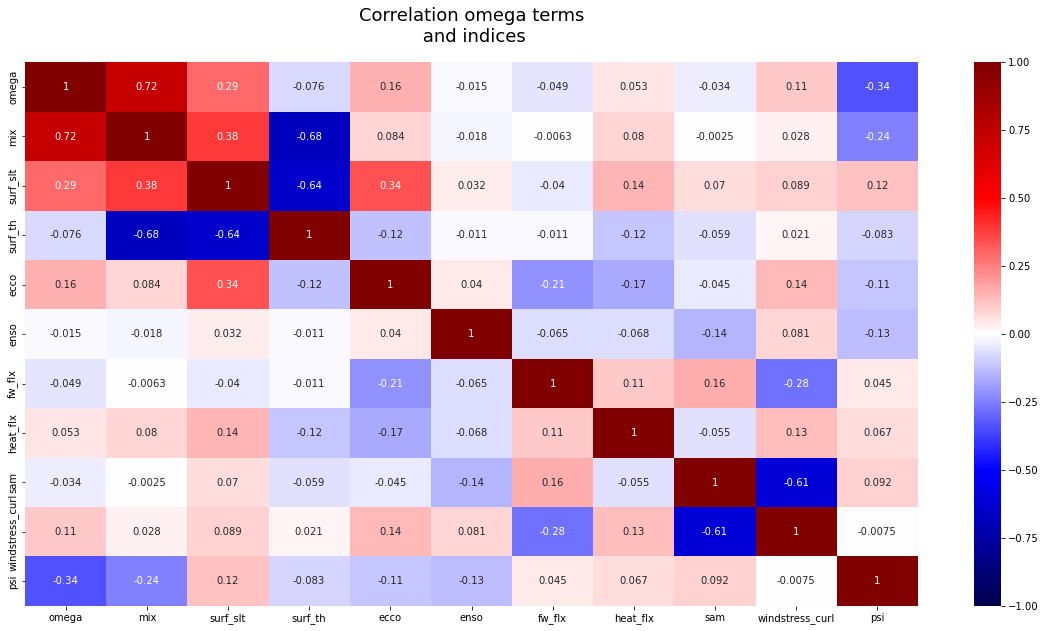

In [134]:
plt.figure(figsize=(20,10))
sn.heatmap(corr_omega, annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation omega terms\n and indices', fontsize=18, pad=20.5);

In [119]:
dvdt_psi = corr.iloc[0, 1]
dvdt_omega = corr.iloc[0, 2]
psi_omega = corr.iloc[2, 1]

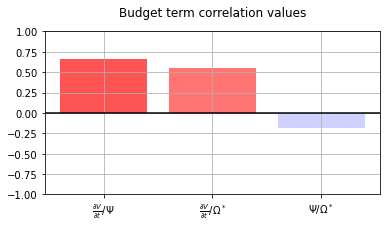

In [120]:
fig, ax0 = plt.subplots(1,1, figsize=(6,3))

ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Psi$', height = dvdt_psi, color='red', alpha=0.67)
ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Omega^*$', height = dvdt_omega, color='red', alpha=0.55)
ax0.bar(x=r'$\Psi/\Omega^*$', height= psi_omega, color='Blue', alpha=0.18)
ax0.axhline(y=0, color='k')
ax0.set_title(r'Budget term correlation values', fontsize=12, pad=15)
ax0.set_ylabel('')
ax0.grid()
ax0.set_ylim(-1,1);

In [169]:
# save df for corr-bars fig in stacked-figs dir
omega_ind.to_csv('ecco_omega_ind')